# Subscription Dashboard Builder

This report is used to develop the metrics to track for the subscription dashboard. The user inputs that must be updated to run this program include the data imports. 

When Flex 20 goes on sale, uncomment those lines to include them in calcs. These lines have been marked with an UPDATE tag at the end

The data includes the PS Subscriber Package Data report

Year over year comparables are not possible at this time because the subscription reports do not have an order date connected to them. Instead, we compare month over month to determine how changes in efforts have driven increases in sales.

## Imports

In [425]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [9]:
cwd = os.getcwd()
print(cwd)

U:\projects\dashboards\subscriptions


## Data Setup

We will start by importing all of the data. The data included with this is:
* bad_data - data containing zone descriptions
* good_data - data containing accurate subscription data (we will merge the zone descriptions from bad data with this)
* prior_data - data from the prior year

When Flex goes on sale we must update and include that data in the model.

#### Fields to use in import

In [413]:
bad_fields = ['summary_cust_id', 'zone_desc']
good_fields = ['customer_no', 'pkg_desc', 'num_seats', 'tot_due_amt']
prior_fields = ['summary_cust_id', 'pkg_desc', 'quantity', 'total_amt', 'zone_desc']
channel_pie_fields = ['channel', 'tot_due_amt']

### Data Imported

#### Used for Comparison Calcs

In [56]:
bad_clx = pd.read_csv(cwd + '/data/sub_packages/FY20-Clx.csv', usecols=bad_fields).drop_duplicates()
bad_pops = pd.read_csv(cwd + '/data/sub_packages/FY20-Pops.csv', usecols=bad_fields).drop_duplicates()
# bad_flex = pd.read_csv(cwd + '/data/sub_packages/FY20-Flex.csv', usecols=bad_fields).drop_duplicates()

In [57]:
good_clx = pd.read_csv(cwd + '/data/sub_pkg_order_listing/Clx20.csv', usecols=good_fields).drop_duplicates()
good_pops = pd.read_csv(cwd + '/data/sub_pkg_order_listing/Pop20.csv', usecols=good_fields).drop_duplicates()
# good_flex = pd.read_csv(cwd + '/data/sub_pkg_order_listing/Flex20.csv', usecols=good_fields).drop_duplicates()

In [54]:
prior_clx = pd.read_csv(cwd + '/data/sub_packages/FY19-Clx.csv', usecols=prior_fields).drop_duplicates()
prior_pops = pd.read_csv(cwd + '/data/sub_packages/FY19-Pops.csv', usecols=prior_fields).drop_duplicates()
prior_flex = pd.read_csv(cwd + '/data/sub_packages/FY19-Flex.csv', usecols=prior_fields).drop_duplicates()

#### Used for Channel Pie

In [415]:
channel_pie_clx = pd.read_csv(cwd + '/data/sub_pkg_order_listing/Clx20.csv', usecols=channel_pie_fields).drop_duplicates()
channel_pie_pops = pd.read_csv(cwd + '/data/sub_pkg_order_listing/Pop20.csv', usecols=channel_pie_fields).drop_duplicates()
# channel_pie_flex = pd.read_csv(cwd + '/data/sub_pkg_order_listing/Flex20.csv', usecols=channel_pie_fields).drop_duplicates()

### Merge Good Data with Zone Description and Rename Columns

In [58]:
col_names = {
    'customer_no': 'summary_cust_id',
    'num_seats': 'quantity',
    'tot_due_amt': 'total_amt'
}

In [64]:
classics = good_clx.merge(bad_clx, left_on='customer_no', right_on='summary_cust_id')\
                   .drop(columns=['summary_cust_id']).rename(columns=col_names)

In [63]:
pops = good_pops.merge(bad_pops, left_on='customer_no', right_on='summary_cust_id')\
                .drop(columns=['summary_cust_id']).rename(columns=col_names)

In [129]:
classics_py = prior_clx.rename(columns=col_names)
pops_py = prior_pops.rename(columns=col_names)
flex_py = prior_flex.rename(columns=col_names)

---

## Comparison Calcs Start

### Identify package type (full or partial)

In [167]:
def pkg_category(df, series):
    """
    Summary:
    Determines the pkg_type (full, partial) of subscription packages.
    
    Description:
    Determines whether a package is full or partial based on the series and number of concerts within the package.
    For example, a package of 7 concerts in the Pops series is 'full'.
    
    Keyword arguments:
    df -- A dataframe containing at least one column labeled 'pkg_desc' (default None)
    series -- Series name is a string describing the concert series in question. The only options are: ('classics', 'pops', 'flex') (default None)
    
    Returns:
    df -- A dataframe containing all original data plus a new column (pkg_type) that contains 'full' or 'partial' as values.
    """
    
    if series.lower() not in ['classics', 'pops', 'flex']:
        raise Exception('The series parameter must be either "classics", "pops", or "flex". It cannot accept any other series name.')
    
    if series == 'classics':
        full = 12
    elif series == 'pops':
        full = 7
    
    quant = df.pkg_desc.map(lambda x: 'full' if x.split(" ")[-1] in [str(full), 'Peel', 'peel'] else 'partial')
    df['pkg_type'] = quant
    
    return df

In [173]:
# This year
classics_pkg_type = pkg_category(classics, 'classics')
pops_pkg_type = pkg_category(pops, 'pops')

# Prior year
classics_py_pkg_type = pkg_category(classics_py, 'classics')
pops_py_pkg_type = pkg_category(pops_py, 'pops')
flex_py['pkg_type'] = 'flex'

### Determine a YoY Comparison

Allows us to see if prior year subscribers upgraded, downgraded, stayed the same, or lapsed.

In [394]:
def yoy_comparison(subs_this_year, subs_last_year, flex_last_year, *flex_this_year):
    """
    Summary:
    Compares this year's subs to last year's subs and flex to determine upgrade, downgrade, retained, etc.
    
    Keyword arguments:
    subs_this_year -- Dataframe consisting of subscriptions for the year in question (cols required = summary_cust_id, pkg_type)
    flex_this_year -- Optional - Dataframe consisting of flex for this year (cols required = summary_cust_id, pkg_type)
    subs_last_year -- Dataframe consisting of subscriptions for the prior year (cols required = summary_cust_id, pkg_type)
    flex_last_year -- Dataframe consisting of flex for the prior_year (cols required = summary_cust_id, pkg_type)
    
    Returns:
    comparison_results -- A dictionary containing keys of retain, new, upgrade, and yet to subscribe.
    """
    
    # Check if flex_this_year is included as an arg. If so, parse the df.
    try:
        flex = flex_this_year[0]
    except:
        flex = pd.DataFrame()
    
    # Create the dataframes for this year (ty) and prior year (py)
    ty = subs_this_year.append(flex)
    py = subs_last_year.append(flex_last_year)
    
    
    # Sort prior year by hierarchy of ['full', 'partial', 'flex']
    # Then drop duplicates so only the top most of the hierarchy is kept.
    ty.pkg_type = pd.Categorical(ty.pkg_type, ['full', 'partial', 'flex'])
    py.pkg_type = pd.Categorical(py.pkg_type, ['full', 'partial', 'flex'])
    
    ty = ty.sort_values(by=['pkg_type']).drop_duplicates(subset=['summary_cust_id'], keep='first')
    py = py.sort_values(by=['pkg_type']).drop_duplicates(subset=['summary_cust_id'], keep='first')

    comparison = ty.merge(py, on='summary_cust_id', how='left')
    
    # Identify numerical verison of full, partial and flex
    comparison['pkg_hierarchy_x'] = comparison['pkg_type_x'].map({'full': 3, 'partial': 2, 'flex': 1})
    comparison['pkg_hierarchy_y'] = comparison['pkg_type_y'].map({'full': 3, 'partial': 2, 'flex': 1})    
    
    comparison_dict = {
        'new': comparison.pkg_type_y.isna().sum(),
        'retain': sum(comparison.pkg_hierarchy_x == comparison.pkg_hierarchy_y),
        'upgrade': sum(comparison.pkg_hierarchy_x > comparison.pkg_hierarchy_y),
        'downgrade': sum(comparison.pkg_hierarchy_x < comparison.pkg_hierarchy_y),
        'total_py': len(py)
    }
    
    comparison_dict.update({
        'yet_to_subscribe': len(py) - comparison_dict['retain'] - comparison_dict['upgrade'] - comparison_dict['downgrade']
    })
    
    
    # RETURNS
    comparison_results = {
        'retain': comparison_dict['retain'] / comparison_dict['total_py'],
        'downgrade': comparison_dict['downgrade'] / comparison_dict['total_py'],
        'upgrade': comparison_dict['upgrade'] / comparison_dict['total_py'],
        'new': comparison_dict['new']
    }
    
    return comparison_results

### Calculate the comparison numbers to use in dashboard

These numbers look at the subscription packages to determine if they moved up, down, stayed the same.

We can also determine how flex performs.

In [410]:
comparison_classics = yoy_comparison(classics[cols_yoy], classics_py[cols_yoy], flex_py[cols_yoy])
comparison_pops = yoy_comparison(pops[cols_yoy], pops[cols_yoy], flex_py[cols_yoy])

## End of Comparison Calcs

---

## Create the Channel Pie

The channel pie examines which channel each of the subscribers are coming from. From here, we can tune into which is performing better or worse than in prior years and what to do about it.

In [499]:
channel_pie_clx = channel_pie_clx.groupby('channel').sum()
channel_pie_pops = channel_pie_pops.groupby('channel').sum()

In [500]:
channel_pie_clx.sort_values(by=['tot_due_amt'], ascending=False, inplace=True)
channel_pie_pops.sort_values(by=['tot_due_amt'], ascending=False, inplace=True)

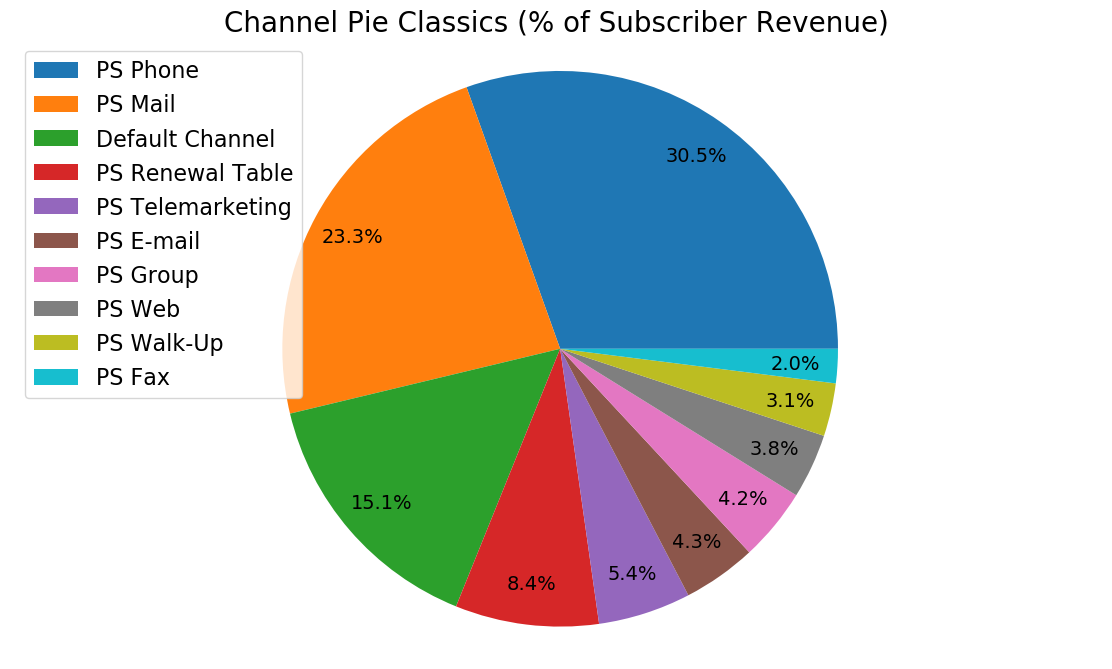

In [501]:
labels = list(channel_pie_clx.index.values)
sizes = list(channel_pie_clx.tot_due_amt.values)

fig1, ax1 = plt.subplots(figsize=(14,8))
ax1.pie(sizes, autopct='%1.1f%%', pctdistance=0.85, textprops={'fontsize': 14})
ax1.legend(labels, fontsize='16')
ax1.axis('equal')
ax1.set_title('Channel Pie Classics (% of Subscriber Revenue)', fontsize='20')

plt.show()

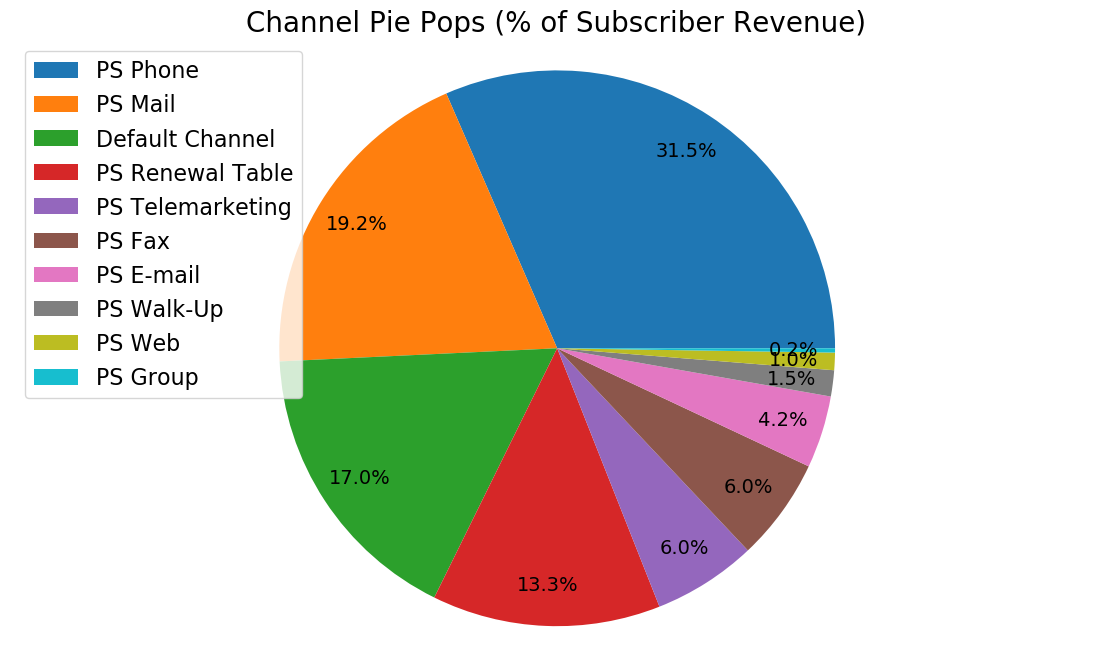

In [502]:
labels = list(channel_pie_pops.index.values)
sizes = list(channel_pie_pops.tot_due_amt.values)

fig1, ax1 = plt.subplots(figsize=(14,8))
ax1.pie(sizes, autopct='%1.1f%%', pctdistance=0.85, textprops={'fontsize': 14})
ax1.legend(labels, fontsize='16')
ax1.axis('equal')
ax1.set_title('Channel Pie Pops (% of Subscriber Revenue)', fontsize='20')

plt.show()

## End of Create Channel Pie

---

## Calculate Revenue

In [517]:
total_rev_clx = sum(good_clx.tot_due_amt)
total_rev_pop = sum(good_pops.tot_due_amt)

total_subs_clx = len(good_clx.customer_no.unique())
total_subs_pop = len(good_pops.customer_no.unique())

In [518]:
total_rev_pop / total_subs_pop

1481.3609271523178

In [519]:
total_rev_clx / total_subs_clx

1198.0494159928123

In [520]:
total_subs_pop + total_subs_clx

1717